# Earth Modeling Prioritized Event Selection Scheme (EMPRESS)

-----
## PART 1: Define the modeling region of interest

### Import initial modules and define plotting functions
<!-- Main dataset contains information, including percentage of box sampling, calculated using `box_sampling.py`. That script must be run before using this notebook. -->

In [1]:
import geo_math
import refmodels
import numpy as np
import pandas as pd
import matplotlib as mpl
import box_sampling_input
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

def convert_azimuth(az):
    if az >= 180.:
        return az - 180.
    else:
        return az

def find_cloud_center(lats, lons):
    lat_rad = np.radians(lats)
    lon_rad = np.radians(lons)
    cloud_x = np.mean(np.cos(lon_rad) * np.cos(lat_rad))
    cloud_y = np.mean(np.sin(lon_rad) * np.cos(lat_rad))
    cloud_z = np.mean(np.sin(lat_rad))

    cloud_lat = np.degrees(np.arcsin(cloud_z / 1.))
    cloud_lon = np.degrees(np.arctan2(cloud_y, cloud_x))
    
    if cloud_lon >= 180.:
        cloud_lon -= 360.
    if cloud_lon < -180:
        cloud_lon += 360

    return [cloud_lat, cloud_lon]

def dist_from_point(start_lat, start_lon, end_lats, end_lons):    
    start_lat_rad = np.radians(start_lat)
    start_lon_rad = np.radians(start_lon + 180.)
    end_lats_rad = np.radians(end_lats)
    end_lons_rad = np.radians(end_lons + 180.)
    
    a = (np.sin((end_lats_rad - start_lat_rad) / 2) ** 2) + np.cos(start_lat_rad) * np.cos(end_lats_rad) * (np.sin((end_lons_rad - start_lon_rad) / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return np.degrees(c)
    
def az_from_point(start_lat, start_lon, end_lats, end_lons):
    delta_lat = end_lats - start_lat
    delta_lon = end_lons - start_lon
        
    start_lat_rad = np.radians(start_lat)
    start_lon_rad = np.radians(start_lon)
    end_lats_rad = np.radians(end_lats)
    end_lons_rad = np.radians(end_lons)
        
    delta_lat_rad = np.radians(delta_lat)
    delta_lon_rad = np.radians(delta_lon)
    
    az_rad = np.arctan2((np.sin(delta_lon_rad) * np.cos(end_lats_rad)), (np.cos(start_lat_rad) * np.sin(end_lats_rad) - np.sin(start_lat_rad) * np.cos(end_lats_rad) * np.cos(delta_lon_rad)))
    az = np.degrees(az_rad)
    
    az = az.mask((az < 0.), (360 - abs(az)))
    az = az.mask((az == 360), 0)
    
    return az

def az_diff(az1, az2):
    az_diff_series = abs(az1 - az2)
    az_diff_series = az_diff_series.mask((az_diff_series > 180), (360 - az_diff_series))

    return az_diff_series

def find_nearest(array, value, type):
    if type == 'absolute':
        array_diff = abs(array - value)
        id = np.where(array_diff == array_diff.min())[0][0]
        return [id]
    
    elif type == 'bounds':
        array_diff = array - value
        smallest_negative_value = array_diff[np.where(array_diff <= 0)].max()
        smallest_positive_value = array_diff[np.where(array_diff >= 0)].min()
        negative_id = np.where(array_diff == smallest_negative_value)[0][0]
        positive_id = np.where(array_diff == smallest_positive_value)[0][0]
        return [negative_id, positive_id]

def lateral_grid_register(df_model, model_wave_type, model_depth, coord_increment, column_name, model_value_type):
    '''
    df_model:
    model_depth:
    coord_increment:
    column_name:
    '''
    prem_vel = refmodels.prem_vel(model_wave_type, model_depth)
    model_depths = df_model.depth.unique()
    array_diff = abs(model_depths - model_depth)
    id = np.where(array_diff == array_diff.min())[0][0]
    ar_model_depth = np.array(df_model.loc[df_model['depth'] == model_depths[id]][['latitude', 'longitude', column_name]].reset_index(drop = True))
    
    reg_lats = np.arange(-90, 90, coord_increment)
    reg_lons = np.arange(-180, 180, coord_increment)
    ar = np.zeros((len(reg_lons), len(reg_lats)))

    lat_idx = 0
    for lat in reg_lats:
        lat_diff = abs(ar_model_depth.T[0] - lat)
        ar_closest_lat = ar_model_depth[np.where(lat_diff == lat_diff.min())[0]]

        lon_idx = 0
        for lon in reg_lons:
            lon_diff = abs(ar_closest_lat.T[1] - lon)
            closest_id = np.where(lon_diff == lon_diff.min())[0][0]
            model_value = ar_closest_lat.T[-1, closest_id]

            if model_value_type == 'velocity':
                if model_value == 0.:
                    model_value = 0.
                else:
                    model_value = ((model_value / prem_vel) * 100.) - 100.
                    
            ar[lon_idx, lat_idx] = model_value
            lon_idx += 1
            
        lat_idx += 1

    ar = ar.T
    return ar

def radial_grid_register(df_model, model_wave_type, start_lat, start_lon, end_lat, end_lon, coord_increment, column_name, model_value_type):
    ar_model = np.array(df_model[['depth', 'latitude', 'longitude', column_name]])
    model_depths = list(df_model.depth.unique())
    x_section_length = geo_math.GCP_length(start_lat, start_lon, end_lat, end_lon)
    x_section_increments = int(x_section_length / coord_increment)
    x_section_increment_length =  x_section_length / x_section_increments
    ar = np.zeros((len(model_depths), x_section_increments + 1))
    
    depth_idx = 0
    for model_depth in model_depths:

        ar_depth = ar_model[np.where(ar_model.T[0] == model_depth)[0]]
        prem_vel = refmodels.prem_vel(model_wave_type, model_depth)
    
        total_dist_along_path = 0
        inc_idx = 0
        for increment in range(x_section_increments + 1):
            # find the closest model value to each incremental point
            # first, find the incremental point
            point_along_path = geo_math.GCP_point(start_lat, start_lon, end_lat, end_lon, x_section_length, total_dist_along_path)
            
            # then, find the nearest model value
            lat_diff = abs(ar_depth.T[1] - point_along_path[0])
            ar_closest_lat = ar_depth[np.where(lat_diff == lat_diff.min())[0]]
    
            lon_diff = abs(ar_closest_lat.T[2] - point_along_path[1])
            closest_pt = ar_closest_lat[np.where(lon_diff == lon_diff.min())[0][0]]
    
            model_value = closest_pt[-1]

            if model_value_type == 'velocity':
                if model_value == 0.:
                    model_value = 0.
                else:
                    model_value = ((model_value / prem_vel) * 100.) - 100.
    
            ar[depth_idx, inc_idx] = model_value
            total_dist_along_path += x_section_increment_length
            inc_idx += 1
            
        depth_idx += 1
    
    return ar

def make_equal_area_grid(side_length, start_lat, start_lon, end_lat, end_lon):
    # presets:
    rad = 6371 # radius
    latitude = []
    circumference_per_lat = []
    
    if (start_lon > 0.) and (end_lon < 0.):
        total_lon = (180 - start_lon) + (180 + end_lon)
    else:
        total_lon = end_lon - start_lon
    
    total_lat = start_lat - end_lat
    lon_ratio = total_lon / 360
    
    # circumference at equator:
    eq_circ = 2 * np.pi * rad

    # gridblock area:
    area = (np.pi/180) * rad**2 * (np.sin(np.deg2rad(side_length)) - np.sin(np.deg2rad(0))) * (side_length)
    
    # degrees of lon in km at the equator:
    deg_in_km = eq_circ / 360
    
    # circumference at other latitudes:
    for lat in range(start_lat, end_lat, side_length):
        latitude.append(lat)
        absolute_lat = np.absolute(lat)
        if lat != 0:
            scale_lat = 90 - absolute_lat
        if lat == 0:
            scale_lat = 90
        scale_factor = scale_lat / 90
        circ = scale_factor * eq_circ
        circumference_per_lat.append(circ)
    
    # block info:
    df_block = pd.DataFrame(data = {'LATITUDE': latitude, 'CIRC': circumference_per_lat})
    df_block['BAND_AREA'] = (rad ** 2) * (np.sin(np.deg2rad(df_block['LATITUDE'] + side_length)) - np.sin(np.deg2rad(df_block['LATITUDE']))) * (np.deg2rad(total_lon))
    df_block['#_OF_BLOCKS'] = df_block['BAND_AREA'] / area
    df_block['#_OF_ROUND_BLOCKS'] = df_block['#_OF_BLOCKS'].round(decimals = 0)
    df_block['#_OF_ROUND_BLOCKS'] = df_block['#_OF_ROUND_BLOCKS'].astype(int)
    df_block['BLOCK_AREA'] = df_block['BAND_AREA'] / df_block['#_OF_ROUND_BLOCKS']
    
    # block file output:
    block_number = []
    lat_band_id = []
    lat_min = []
    lat_max = []
    lon_min = []
    lon_max = []
    center_lat = []
    center_lon = []
    
    # initialize lat band id
    lat_band = 1
    ref_start_lat = start_lat
    
    # effectively, for each latitude band:
    for line in range(len(df_block)):
        number_of_blocks = df_block['#_OF_ROUND_BLOCKS'].iloc[line]
        lon_division = total_lon / number_of_blocks
        ref_start_lon = start_lon
    
        for num in range(number_of_blocks):
            lat_min.append(ref_start_lat)
            lat_max.append(ref_start_lat + side_length)
            center_lat.append(ref_start_lat + (side_length / 2))
            lat_band_id.append(lat_band)
    
            lon_min.append(ref_start_lon)
            lon_max.append(ref_start_lon + lon_division)
            center_lon.append(ref_start_lon + (lon_division / 2))
    
            ref_start_lon += lon_division
            if ref_start_lon >= 180.:
                ref_start_lon -= 360
    
        lat_band += 1
        ref_start_lat += side_length
    
    block_dim_data = {'BLOCK#': list(range(1, len(lat_min) + 1)), 'LAT_BAND_ID': lat_band_id, 'LAT_MIN': lat_min, 'LAT_MAX': lat_max, 'LON_MIN': lon_min, 'LON_MAX': lon_max, 'CENTER_LAT': center_lat, 'CENTER_LON': center_lon}
    df_block_dim = pd.DataFrame(data = block_dim_data)
    df_block_dim['LON_MAX'].mask((df_block_dim['LON_MAX'] >= 180.), (df_block_dim['LON_MAX'] - 360.), inplace = True)
    return df_block_dim

def find_block_id(lat, lon, ar_blocks):
    '''
    Function to find the block ID that a given latitude and longitude pair belong to
    ======
    Inputs:
    - `lat`: latitude [format: float or int; unit: degrees]
    - `lon`: longitude [format: float or int; unit: degrees]
    - `df_blocks`: numpy array object of approximate equal area 2D blocks (generated as a pandas dataframe from `make_equal_area_grid`) 
    Outputs:
    - block ID of block in which `(lat1, lon1)` falls [format: int; unit: unitless]
    ======
    '''
    ar_blocks_t = ar_blocks.T
    if lon >= 180.:
        lon -= 360.
        
    if lat != 90.:
        block_idx = np.where((ar_blocks_t[2] <= lat) & (ar_blocks_t[3] > lat) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0]
        if len(block_idx) == 0:
            block_id = np.where((ar_blocks_t[2] <= lat) & (ar_blocks_t[3] > lat) & (ar_blocks_t[4] > 0) & (ar_blocks_t[5] < 0))[0][0] + 1
        else:
            block_id = np.where((ar_blocks_t[2] <= lat) & (ar_blocks_t[3] > lat) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0][0] + 1
    
    elif lat == 90.:
        block_idx = np.where((ar_blocks_t[3] == 90.) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0]
        if len(block_idx) == 0:
            block_id = np.where((ar_blocks_t[3] == 90.) & (ar_blocks_t[4] > 0) & (ar_blocks_t[5] < 0))[0][0] + 1
        else:
            block_id = np.where((ar_blocks_t[3] == 90.) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0][0] + 1
    return int(block_id) 

azimuthal_sectors = 6
azimuthal_sector_extent = 180. / azimuthal_sectors
df_sectors = pd.DataFrame(columns = ['sector', 'min_extent', 'max_extent'])
sector_nos = list(range(1, azimuthal_sectors + 1))
df_sectors['sector'] = sector_nos
df_sectors['min_extent'] = (df_sectors['sector'] - 1) * azimuthal_sector_extent
df_sectors['max_extent'] = df_sectors['sector'] * azimuthal_sector_extent
df_sectors = np.array(df_sectors.T)

def azimuthal_sector(az):
    '''
    define a function to determin the azimuthal sector of an input azimuth
    '''
    if az == 360.:
        az = 0.
    if az >= 180.:
        az -= 180.
    return int(np.where((df_sectors[1] <= az) & (df_sectors[2] > az))[0][0] + 1)

def coverage_mesh(ar_blocks, ar_coverage, coord_increment, column_index):
    reg_lats = np.arange(s, n, coord_increment)
    reg_lons = np.arange(0, box_sampling_input.width, coord_increment)
    reg_lons = reg_lons + w
    reg_lons[np.where(reg_lons >= 180)[0]] = reg_lons[np.where(reg_lons >= 180)[0]] - 360    
    ar = np.zeros((len(reg_lons), len(reg_lats)))

    lat_idx = 0
    for lat in reg_lats:
        lat_vals = []
        lon_idx = 0
        for lon in reg_lons:
            block = find_block_id(lat, lon, ar_blocks)
            value = ar_coverage[np.where(ar_coverage.T[0] == block)[0][0], column_index]
            ar[lon_idx, lat_idx] = value
            lon_idx += 1
        lat_idx += 1
    return ar.T


### Vizualize the focus region
Use this section to help define the desired region. To do this, toggle the following variables in `box_sampling_input.py`:

- `box_depth_min`
- `box_depth_max`
- `width`
- `height`
- `west`
- `south`

If you wish to plot your defined region over a tomography model, make sure a CSV of the model is saved in `./models/{model}.csv`. Then, define the model name and depth shell (for map-view):

In [2]:
model = 'S40RTS_vsh' # model name from './models' directory. If no model layer is desired for the map, define as `None`
model_wave_type = 'S'
model_depth = 2800 # depth shell to plot on the lateral map
model_value = 'vsh'
model_value_type = 'perturbation' # 'perturbation' or 'velocity'
map_increment = 1

# cross section attributes (must be less than 180 degrees in extent)
start_point = [0, 117]
end_point = [-0, -67]

number_of_reference_points = 3
tomo_cm = 'RdBu'
tomo_bar_val = 2

west: 120, south: -70, east: -70, north: 40

CPU times: user 18.6 s, sys: 2.14 s, total: 20.7 s
Wall time: 21.1 s


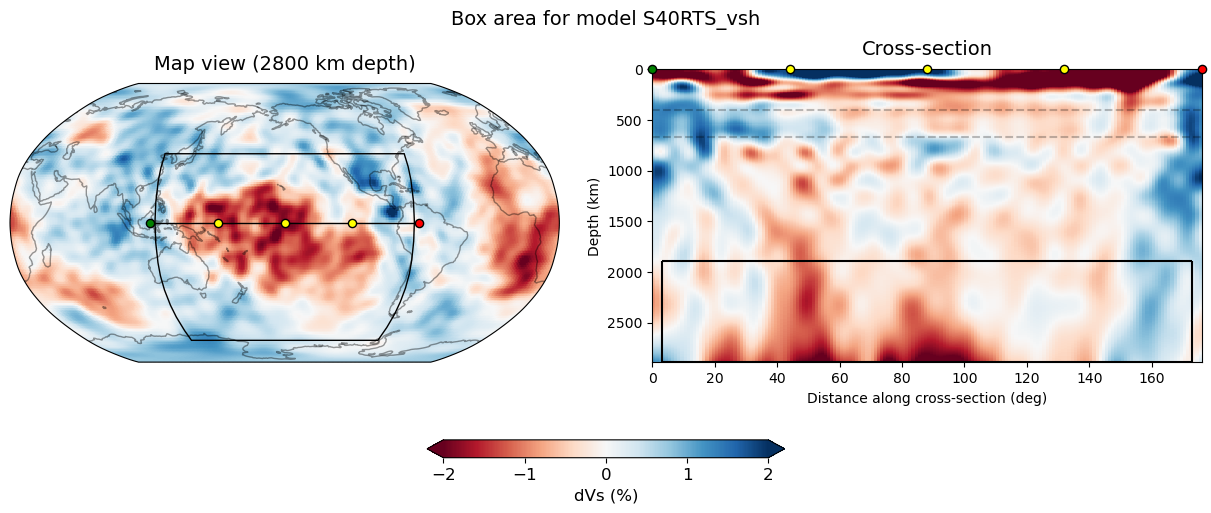

In [4]:
%%time
fig = plt.figure(figsize = (12,5), constrained_layout = True)
lats = np.arange(-90, 90, map_increment)
lons = np.arange(-180, 180, map_increment)

# define map extents
w = box_sampling_input.west
s = box_sampling_input.south
e = w + box_sampling_input.width
if e >= 180.:
    e -= 360
n = s + box_sampling_input.height
if n >= 90.:
    print(f'--  Northern extent too large, n = {n}; adjust `height` variable in `box_sampling_input.py`')

map_center = w + (box_sampling_input.width / 2)
if map_center >= 180.:
    map_center -= 360

# define x-sec extents:
xsec_length = geo_math.GCP_length(start_point[0], start_point[1], end_point[0], end_point[1])
reference_dot_spacing = xsec_length / (number_of_reference_points + 1)
xsec_az = geo_math.azimuth(start_point[0], start_point[1], end_point[0], end_point[1])


## map view setup:
ax1 = fig.add_subplot(1, 2, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], c = 'k', transform = ccrs.Geodetic(), linewidth = 1, zorder = 2)
ax1.scatter(start_point[1], start_point[0], transform = ccrs.Geodetic(), c = 'green', marker = '.', edgecolor = 'black', s = 140, zorder = 3)
ax1.scatter(end_point[1], end_point[0], transform = ccrs.Geodetic(), c = 'red', marker = '.', edgecolor = 'black', s = 140, zorder = 3)

## cross-section view setup:
ax2 = fig.add_subplot(1, 2, 2)
ax2.annotate(f'Cross-section', xy = (0.5, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 14)
ax2.scatter(0., 0., c = 'green', marker = '.', edgecolor = 'black', s = 140, zorder = 3, clip_on = False)
ax2.scatter(xsec_length, 0., c = 'red', marker = '.', edgecolor = 'black', s = 140, zorder = 3, clip_on = False)
ax2.axhline(y = 400., c = 'k', linestyle = '--', alpha = 0.25)
ax2.axhline(y = 670., c = 'k', linestyle = '--', alpha = 0.25)
ax2.invert_yaxis()
ax2.set_ylim(2891, 0)
ax2.set_xlim(0, xsec_length)
ax2.set_ylabel('\nDepth (km)')
ax2.set_xlabel('Distance along cross-section (deg)')

## reference dots:
reference_dot_dist = 0
for reference_point in range(number_of_reference_points):
    reference_dot_dist += reference_dot_spacing
    reference_dot_coords = geo_math.GCP_point(start_point[0], start_point[1], end_point[0], end_point[1], xsec_length, reference_dot_dist)
    ax1.scatter(reference_dot_coords[1], reference_dot_coords[0], transform = ccrs.Geodetic(), c = 'yellow', marker = '.', edgecolor = 'black', s = 140, zorder = 3)
    ax2.scatter(reference_dot_dist, 0, c = 'yellow', marker = '.', edgecolor = 'black', s = 140, zorder = 3, clip_on = False)

## add model:
if model != None:
    ## map view:
    df_model = pd.read_csv(f'./models/{model}.csv')
    df_model = df_model.loc[df_model['depth'] >= 0]
    depths = list(df_model.depth.unique())
    depths.insert(0, 0)
    mod_dvs = lateral_grid_register(df_model, model_wave_type, model_depth, map_increment, model_value, model_value_type)
    im1 = ax1.pcolormesh(lons, lats, mod_dvs, transform = ccrs.PlateCarree(), cmap = tomo_cm, vmin = -tomo_bar_val, vmax = tomo_bar_val)
    ax1.annotate(f'Map view ({model_depth} km depth)', xy = (0.5, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 14)
    suptitle = f'Box area for model {model}'

    ## x-section:
    xsec_dvs = radial_grid_register(df_model, model_wave_type, start_point[0], start_point[1], end_point[0], end_point[1], map_increment, model_value, model_value_type)
    ax2.pcolormesh(range(0, len(xsec_dvs.T) + 1), depths, xsec_dvs, cmap = tomo_cm, vmin = -tomo_bar_val, vmax = tomo_bar_val)

    ## colorbar:
    cbar_tomo = fig.colorbar(im1, ax = [ax1, ax2], orientation = 'horizontal', shrink = 0.3, pad = 0.1, extend = 'both')
    cbar_tomo.ax.tick_params(labelsize = 12)
    cbar_tomo.ax.set_xlabel('dVs (%)', size = 12)
    
else:
    ax1.annotate(f'Map view', xy = (0.5, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 14)
    zero_ar = np.zeros((1, 1))
    ax2.pcolormesh([0, xsec_length], [0, 2891], zero_ar, cmap = tomo_cm, vmin = 0, vmax = 0)
    suptitle = f'Box area'

## add box outline:
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))


x_pts = []

# # find the coordinates of all of the boundaries from the start point
try:
    start_to_w = geo_math.known_lon(xsec_az, start_point[0], start_point[1], w)
    if start_to_w[2] <= xsec_length:
        x_pts.append(start_to_w[2])
except:
    pass
try:
    start_to_e = geo_math.known_lon(xsec_az, start_point[0], start_point[1], e)
    if start_to_e[2] <= xsec_length:
        x_pts.append(start_to_e[2])
except:
    pass
try:
    start_to_s = geo_math.known_lat(xsec_az, start_point[0], start_point[1], s)
    if start_to_s[2] <= xsec_length:
        x_pts.append(start_to_s[2])
except:
    pass
try:
    start_to_n = geo_math.known_lat(xsec_az, start_point[0], start_point[1], n)
    if start_to_n[2] <= xsec_length:
        x_pts.append(start_to_n[2])
except:
    pass
    
for x_pt in x_pts:
    ax2.vlines(x_pt, box_sampling_input.box_depth_min, box_sampling_input.box_depth_max, colors = 'k')

if len(x_pts) == 0:
    ax2.axhline(box_sampling_input.box_depth_min, c = 'k')
    ax2.axhline(box_sampling_input.box_depth_max, c = 'k')
elif len(x_pts) == 1:
    # find which side of the plot to draw the line to 
    if (s < start_point[0] < n) and ((w < start_point[1]) or (e > start_point[1])):
        ax2.hlines(box_sampling_input.box_depth_min, x_pts[0], 0, colors = 'k')
        ax2.hlines(box_sampling_input.box_depth_max, x_pts[0], 0, colors = 'k')
    elif (s < end_point[0] < n) and ((w < end_point[1]) or (e > end_point[1])):
        print('lj')
        ax2.hlines(box_sampling_input.box_depth_min, x_pts[0], xsec_length, colors = 'k')
        ax2.hlines(box_sampling_input.box_depth_max, x_pts[0], xsec_length, colors = 'k')
elif len(x_pts) == 2:
    ax2.hlines(box_sampling_input.box_depth_min, x_pts[0], x_pts[1], colors = 'k')
    ax2.hlines(box_sampling_input.box_depth_max, x_pts[0], x_pts[1], colors = 'k')

fig.suptitle(suptitle, fontsize = 14);
print(f'west: {w}, south: {s}, east: {e}, north: {n}')
print()

---
## PART 2: Compute the total percent of each 1D raypath represented by the event/station pairs in the input file

To do this, run `box_sampling.py`, which can take several hours depending on the size of the input files and processing speed of the computer used to run the script. Then, define the dataset.

In [5]:
df_data = pd.read_csv(box_sampling_input.dataset_save_name)
print(f'number of raypaths represented in the dataset before initial filtering: {len(df_data)}')
print()
display(df_data)

number of raypaths represented in the dataset before initial filtering: 262315



,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,STA_LAT,STA_LON,PHASE,COMPREHENSIVE_WEIGHT,AZIMUTH,MEAN_AZ_IN_BOX,STD_AZ_IN_BOX,MAX_DEPTH_KM,TOTAL_LENGTH_KM,LENGTH_IN_BOX_KM,%_IN_BOX
0,1.994011e+13,-13.339,-69.446,6.9,596.0,-20.488,-45.639,ScSScS,0.274536,110.694483,NaN,NaN,2891.0,11139.831232,0.000000,0.000000
1,1.994011e+13,-13.339,-69.446,6.9,596.0,35.889,-120.426,ScSScS,0.271667,317.548897,317.410890,0.961740,2891.0,12319.521965,4828.689865,39.195432
2,1.994011e+13,-13.339,-69.446,6.9,596.0,36.764,-121.447,ScSScS,0.431167,317.797742,317.572735,1.053649,2891.0,12363.219670,4857.297029,39.288285
3,1.994011e+13,-13.339,-69.446,6.9,596.0,37.876,-122.236,ScSScS,0.285187,318.378067,318.045579,1.159199,2891.0,12406.549941,4885.778049,39.380634
4,1.994011e+13,-13.339,-69.446,6.9,596.0,41.732,-122.710,ScSScS,0.405000,321.455739,320.787029,1.453638,2891.0,12503.384601,4949.840025,39.588001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262310,2.017022e+13,-23.259,-178.804,6.9,414.5,41.540,-81.360,ScSScSScSScS,0.050000,52.429272,52.044507,5.342212,2891.0,24465.078985,9038.362742,36.943934
262311,2.017022e+13,-23.259,-178.804,6.9,414.5,40.610,-79.170,ScSScSScSScS,0.050000,53.797319,53.192837,5.321461,2891.0,24507.945215,9064.908398,36.987631
262312,2.017022e+13,-23.259,-178.804,6.9,414.5,43.980,-75.650,ScSScSScSScS,0.050000,50.710303,47.866548,1.803462,2891.0,24606.928465,6844.811969,27.816604
262313,2.017022e+13,-23.259,-178.804,6.9,414.5,45.900,-75.610,ScSScSScSScS,0.050000,48.614048,46.156832,1.860336,2891.0,24616.617102,6849.339163,27.824047


### Filter the dataset of raypaths by the newly computed coverage criteria

Interactively apply any filters to `df_data`.
Note: this cell creates a new copy of `df_data` everytime it's run, so you can rerun it as many times as necessary to try new/different combinations of filters.

In [6]:
df_filtered_data = df_data.copy()

while True:
    add_filter = str(input(f'Do you have a filter to add? [y / n]: '))
    if add_filter == 'n':
        break
    
    elif add_filter == 'y':
        other_value_header = str(input(f'What is the header in `df_data` of the filter you would like to add?: '))
        while other_value_header not in df_data.columns:
            other_value_header = str(input(f'Sorry, that header is not in `df_data`. Is there another header you would like to try?: '))
        
        # t = type(df_filtered_data[other_value_header].iloc[0])
        
        if other_value_header == 'PHASE':
            other_value_filter = str(input(f'What phase or phases would you like to apply a filter to (format is either `phase` or `phase1, phase2,...`)?: '))
            other_value_filter_type = str(input(f'Would you like to exclude {other_value_filter} or make a dataframe of raypaths that exclusively matches {other_value_filter}? [exclude / match]: '))
            
            if ', ' in other_value_filter:
                other_value_filter = other_value_filter.split(', ')

            if other_value_filter_type == 'exclude':
                if type(other_value_filter) == str:
                    df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] != other_value_filter]
                elif type(other_value_filter) == list:
                    df_filtered_data = df_filtered_data.loc[~df_filtered_data[other_value_header].isin(other_value_filter)]
                    
            elif other_value_filter_type == 'match':
                if type(other_value_filter) == str:
                    df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] == other_value_filter]
                elif type(other_value_filter) == list:
                    df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header].isin(other_value_filter)]
        
        else:
            other_value_filter = float(input(f'What is the value of the filter you would like to apply?: '))
            other_value_filter_type = str(input(f'Is the given value a maximum or minimum requirement? [max / min]: '))
            if other_value_filter_type == 'min':
                df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] >= other_value_filter]
            elif other_value_filter_type == 'max':
                df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] <= other_value_filter]
        
        print(f'You have {len(df_filtered_data)} of {len(df_data)} raypaths in your filtered dataset')
        print()
    
    else:
        pass

df_filtered_data = df_filtered_data.reset_index(drop = True)
print()
print(f'You have {len(df_filtered_data)} of {len(df_data)} raypaths in your filtered dataset')
display(df_filtered_data)

Do you have a filter to add? [y / n]:  y
What is the header in `df_data` of the filter you would like to add?:  %_IN_BOX
What is the value of the filter you would like to apply?:  30
Is the given value a maximum or minimum requirement? [max / min]:  min


You have 52348 of 262315 raypaths in your filtered dataset



Do you have a filter to add? [y / n]:  y
What is the header in `df_data` of the filter you would like to add?:  COMPREHENSIVE_WEIGHT
What is the value of the filter you would like to apply?:  0.6
Is the given value a maximum or minimum requirement? [max / min]:  min


You have 19935 of 262315 raypaths in your filtered dataset



Do you have a filter to add? [y / n]:  n



You have 19935 of 262315 raypaths in your filtered dataset


,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,STA_LAT,STA_LON,PHASE,COMPREHENSIVE_WEIGHT,AZIMUTH,MEAN_AZ_IN_BOX,STD_AZ_IN_BOX,MAX_DEPTH_KM,TOTAL_LENGTH_KM,LENGTH_IN_BOX_KM,%_IN_BOX
0,1.994011e+13,-13.339,-69.446,6.9,596.0,44.417,-121.689,S,0.904400,324.162103,325.172099,0.000000,2076.309911,7498.135136,2254.604347,30.068868
1,1.994011e+13,-13.339,-69.446,6.9,596.0,-17.569,-149.576,S,1.000000,254.753346,260.073916,0.000000,2153.294744,7672.811024,2680.628330,34.936718
2,1.994011e+13,-13.339,-69.446,6.9,596.0,-13.909,-171.777,S,1.000000,253.454096,256.521265,0.000000,2842.174538,9277.681369,5289.788778,57.016280
3,1.994031e+13,15.994,-92.428,6.9,164.2,-13.909,-171.777,S,0.784667,253.614127,249.481470,0.000000,2340.515784,8562.924650,3500.716836,40.882257
4,1.994033e+13,-22.057,-179.533,6.5,579.8,-42.975,171.579,ScS,0.660000,197.417642,198.008108,0.000000,2891.000000,5501.447517,2179.433281,39.615633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19930,2.017022e+13,-23.259,-178.804,6.9,414.5,40.170,-75.190,ScSScSScS,0.640000,54.917828,53.746771,4.319363,2891.000000,19370.649634,7502.702919,38.732325
19931,2.017022e+13,-23.259,-178.804,6.9,414.5,36.720,-89.470,ScSScSScSScS,0.810000,55.396837,53.212589,3.682810,2891.000000,24246.584708,8903.909940,36.722326
19932,2.017022e+13,-23.259,-178.804,6.9,414.5,33.860,-84.060,ScSScSScSScS,0.620000,59.639174,56.512695,3.490914,2891.000000,24342.322597,8962.647851,36.819198
19933,2.017022e+13,-23.259,-178.804,6.9,414.5,35.450,-84.520,ScSScSScSScS,0.730000,57.938368,55.362614,3.749393,2891.000000,24345.536836,8964.624621,36.822456


### Show phase representation

In [7]:
unique_filtered_phases = df_filtered_data.PHASE.unique()
display(df_filtered_data.groupby(['PHASE']).size().reset_index())
total_unique_phases = len(unique_filtered_phases)

,PHASE,0
0,S,14275
1,SS,477
2,ScS,957
3,ScSScS,327
4,ScSScSScS,267
5,ScSScSScSScS,58
6,ScSScSScSScSScS,4
7,Sdiff,3570


---
## PART 3: Compile prioritized event dataset

### Find all unique events and additional values for filtering criteria

Filtering criteria includes the following for each unique event:
- the number of pre-filtered raypaths (from Part 2)
- the averages of any weights from the input dataset to be considered (defined in `box_sampling_input.input_weights`)
- the range of azimuths (defined from 0-180)
- the mean of the azimuthal spacing between raypaths (indicates the approximate spacing of the raypaths in terms of azimuth)
- the standard deviation of the mean of the azimuthal spacing between raypaths (indicates the variability of the azimuthal spacing between raypaths)

In [8]:
unique_events = df_filtered_data['EVENT_ID'].unique()
df_unique_events = pd.DataFrame(data = {'EVENT_ID': unique_events})
df_unique_events['EQ_LAT'] = 0.
df_unique_events['EQ_LON'] = 0.
df_unique_events['RAYPATHS'] = 0

for col in box_sampling_input.input_weights:
    df_unique_events[col] = 0.
df_unique_events['AZ_RANGE'] = 0.
df_unique_events['AZ_SPACING_MEAN'] = 0.
df_unique_events['AZ_SPACING_STD'] = 0.
df_unique_events['UNIQUE_PHASES'] = 0
df_unique_events['PERCENT_OF_PHASES_REPRESENTED'] = 0.

# for each event, add average weights from the input dataset
for event in range(len(df_unique_events)):
    event_id = df_unique_events['EVENT_ID'].iloc[event]
    df_event = df_filtered_data.loc[df_filtered_data['EVENT_ID'] == event_id].copy()
    df_unique_events.loc[event, 'UNIQUE_PHASES'] = len(df_event.PHASE.unique())
    df_unique_events.loc[event, 'PERCENT_OF_PHASES_REPRESENTED'] = round((len(df_event.PHASE.unique()) / total_unique_phases) * 100, 1)
    df_unique_events.loc[event, 'EQ_LAT'] = df_event['EQ_LAT'].iloc[0]
    df_unique_events.loc[event, 'EQ_LON'] = df_event['EQ_LON'].iloc[0]
    df_unique_events.loc[event, 'RAYPATHS'] = len(df_event)

    for col in box_sampling_input.input_weights:
        df_unique_events.loc[event, col] = df_event[col].mean()
    
    if len(df_event) == 1:
        df_unique_events.loc[event, 'AZ_RANGE'] = np.nan
        df_unique_events.loc[event, 'AZ_SPACING_MEAN'] = np.nan
        df_unique_events.loc[event, 'AZ_SPACING_STD'] = np.nan
        
    else:
        sorted_az = df_event['AZIMUTH'].apply(convert_azimuth).sort_values()        
        df_unique_events.loc[event, 'AZ_RANGE'] = sorted_az.max() - sorted_az.min()
        df_unique_events.loc[event, 'AZ_SPACING_MEAN'] = sorted_az.diff()[1:].mean()
        df_unique_events.loc[event, 'AZ_SPACING_STD'] = sorted_az.diff()[1:].std()


cloud_center = find_cloud_center(df_unique_events['EQ_LAT'], df_unique_events['EQ_LON'])

df_unique_events['DIST_FROM_CENTER'] = dist_from_point(cloud_center[0], cloud_center[1], df_unique_events['EQ_LAT'], df_unique_events['EQ_LON'])
df_unique_events['AZ_FROM_CENTER'] = az_from_point(cloud_center[0], cloud_center[1], df_unique_events['EQ_LAT'], df_unique_events['EQ_LON'])
df_unique_events['CUMULATIVE_DIST'] = 0
df_unique_events['CUMULATIVE_AZ'] = 0

for event in range(len(df_unique_events)):
    eq_lat = df_unique_events['EQ_LAT'].iloc[event]
    eq_lon = df_unique_events['EQ_LON'].iloc[event]
    az_from_center = df_unique_events['AZ_FROM_CENTER'].iloc[event]

    # find the cumulative epicentral distance to every other point
    df_unique_events.loc[event, 'CUMULATIVE_DIST'] = np.sum(dist_from_point(eq_lat, eq_lon, df_unique_events['EQ_LAT'], df_unique_events['EQ_LON']))

    # find the cumulative angle between this event, the cloud center, and every other event
    df_unique_events.loc[event, 'CUMULATIVE_AZ'] = np.sum(az_diff(az_from_center, df_unique_events['AZ_FROM_CENTER']))

df_unique_events['DISPERSION_SCORE'] = (df_unique_events['CUMULATIVE_DIST'] / df_unique_events['CUMULATIVE_DIST'].max()) + (df_unique_events['CUMULATIVE_AZ'] / df_unique_events['CUMULATIVE_AZ'].max())
df_unique_events['DISPERSION_SCORE'] = df_unique_events['DISPERSION_SCORE'] / df_unique_events['DISPERSION_SCORE'].max()
df_unique_events = df_unique_events.sort_values(by = ['DISPERSION_SCORE'], ascending = False).reset_index(drop = True)
df_unique_events['DISPERSION_ORDER'] = list(range(1, len(df_unique_events) + 1))

# df_unique_events = df_unique_events.sort_values(by = 'RAYPATHS', ascending = True).reset_index(drop = True)
display(df_unique_events)

,EVENT_ID,EQ_LAT,EQ_LON,RAYPATHS,COMPREHENSIVE_WEIGHT,AZ_RANGE,AZ_SPACING_MEAN,AZ_SPACING_STD,UNIQUE_PHASES,PERCENT_OF_PHASES_REPRESENTED,DIST_FROM_CENTER,AZ_FROM_CENTER,CUMULATIVE_DIST,CUMULATIVE_AZ,DISPERSION_SCORE,DISPERSION_ORDER
0,2.009031e+13,80.324,-1.853,1,0.609583,NaN,NaN,NaN,1,12.5,102.924330,1.866117,24082.005628,24756.383461,1.000000,1
1,2.006093e+13,10.876,-61.756,6,0.673958,53.004028,10.600806,15.226934,2,25.0,109.502747,79.669554,24334.271875,24014.073729,0.990493,2
2,2.013101e+13,10.905,-62.315,4,0.657312,53.146091,17.715364,23.356518,2,25.0,108.953740,79.640386,24264.789283,24014.569579,0.989043,3
3,2.014011e+13,19.043,-66.810,34,0.792962,124.409749,3.769992,11.489546,4,50.0,104.495006,71.208102,23802.507025,24251.596740,0.984056,4
4,2.015031e+13,6.776,-72.988,7,0.871143,178.104556,29.684093,31.038509,2,25.0,98.317745,83.644117,22875.036126,23946.630090,0.958479,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2.014123e+13,-20.326,-178.564,205,0.910284,139.528017,0.683961,2.833540,4,50.0,18.450259,203.058286,15448.935356,18760.920426,0.698955,243
243,2.014072e+13,-19.802,-178.400,765,0.959552,162.394210,0.212558,0.878758,4,50.0,17.909875,203.312528,15445.180621,18762.700119,0.698912,244
244,2.014072e+13,-19.802,-178.400,151,0.824106,46.189854,0.307932,0.815166,3,37.5,17.909875,203.312528,15445.180621,18762.700119,0.698912,245
245,2.006010e+13,-19.926,-178.178,317,0.933895,150.067124,0.474896,1.957850,6,75.0,17.936483,202.528180,15446.311434,18759.904890,0.698880,246


### Plot a histogram showing the # of raypaths (event/station pairs) per unique event, and a corresponding map of events

In [9]:
col_to_plot = 'RAYPATHS'

Text(0.5, 0, 'RAYPATHS')

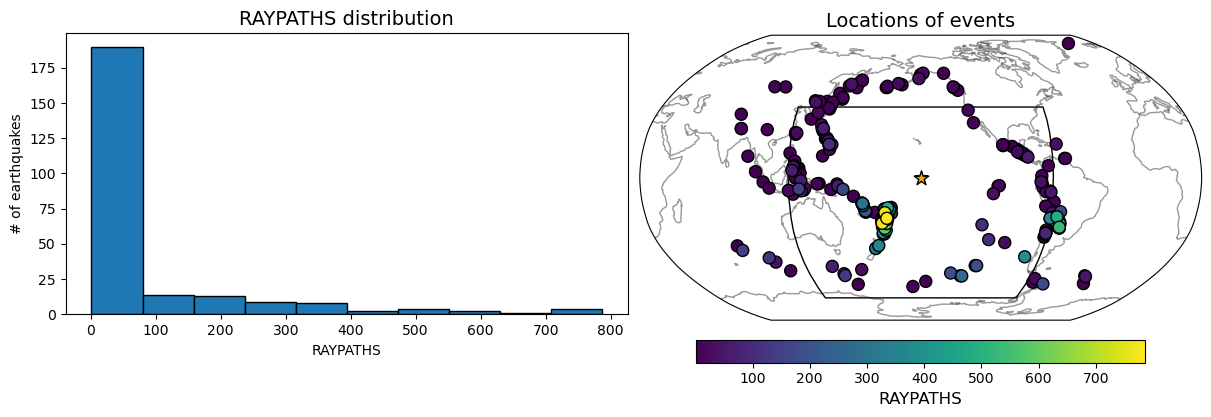

In [10]:
if (col_to_plot == 'DISPERSION_ORDER'):
    ascending_kw = False
    cm = 'viridis_r'
else:
    ascending_kw = True
    cm = 'viridis'

df_unique_events = df_unique_events.sort_values(by = [col_to_plot], ascending = ascending_kw).reset_index(drop = True)

fig = plt.figure(figsize = (12, 4), constrained_layout = True)
ax0 = fig.add_subplot(1, 2, 1)#, aspect = 2)
ax0.set_box_aspect(.5)
ax0.hist(df_unique_events[col_to_plot], edgecolor = 'k')
ax0.set_title(f'{col_to_plot} distribution', fontsize = 14)
ax0.set_xlabel(f'{col_to_plot}')
ax0.set_ylabel('# of earthquakes');

ax1 = fig.add_subplot(1, 2, 2, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.scatter(cloud_center[1], cloud_center[0], c = 'orange', marker = '*', s = 120, edgecolor = 'k')
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))
ax1.set_title(f'Locations of events', fontsize = 14)
im1 = ax1.scatter(df_unique_events['EQ_LON'], df_unique_events['EQ_LAT'], c = df_unique_events[col_to_plot], transform = ccrs.PlateCarree(), edgecolor = 'k', marker = 'o', s = 75, cmap = cm, alpha = 1, zorder = 2)
cbar = fig.colorbar(im1, ax = [ax1], orientation = 'horizontal', shrink = 0.8, pad = -0.05)
cbar.ax.set_xlabel(f'{col_to_plot}', size = 12)


### Apply any additional filters before applying prioritization

In [11]:
df_filtered_events = df_unique_events.copy()

while True:
    add_filter = str(input(f'Do you have a filter to add? [y / n]: '))
    if add_filter == 'n':
        break
    
    elif add_filter == 'y':
        other_value_header = str(input(f'What is the header in `df_unique_events` of the filter you would like to add?: '))
        
        while other_value_header not in df_filtered_events.columns:
            other_value_header = str(input(f'Sorry, that header is not in `df_unique_events`. Is there another header you would like to try?: '))
            
        other_value_filter = float(input(f'What is the value of the filter you would like to apply?: '))
        other_value_filter_type = str(input(f'Is the given value a maximum or minimum requirement? [max / min]: '))
        if other_value_filter_type == 'min':
            df_filtered_events = df_filtered_events.loc[df_filtered_events[other_value_header] >= other_value_filter]
        elif other_value_filter_type == 'max':
            df_filtered_events = df_filtered_events.loc[df_filtered_events[other_value_header] <= other_value_filter]

        print(f'You have {len(df_filtered_events)} of {len(df_unique_events)} events in your filtered dataset')
        print()
    
    else:
        pass

df_filtered_events = df_filtered_events.reset_index(drop = True)
print()
print(f'You have {len(df_filtered_events)} of {len(df_unique_events)} events in your filtered dataset')
display(df_filtered_events)

Do you have a filter to add? [y / n]:  y
What is the header in `df_unique_events` of the filter you would like to add?:  RAYPATHS
What is the value of the filter you would like to apply?:  20
Is the given value a maximum or minimum requirement? [max / min]:  min


You have 105 of 247 events in your filtered dataset



Do you have a filter to add? [y / n]:  n



You have 105 of 247 events in your filtered dataset


,EVENT_ID,EQ_LAT,EQ_LON,RAYPATHS,COMPREHENSIVE_WEIGHT,AZ_RANGE,AZ_SPACING_MEAN,AZ_SPACING_STD,UNIQUE_PHASES,PERCENT_OF_PHASES_REPRESENTED,DIST_FROM_CENTER,AZ_FROM_CENTER,CUMULATIVE_DIST,CUMULATIVE_AZ,DISPERSION_SCORE,DISPERSION_ORDER
0,2.012041e+13,-57.679,-65.308,21,0.813588,156.025818,7.801291,20.702171,2,25.0,95.368714,148.863151,22296.580541,21325.875566,0.894040,91
1,2.014071e+13,14.724,-92.461,22,0.864769,169.097872,8.052280,18.638505,2,25.0,79.794910,74.366223,20909.135269,24136.975345,0.920960,59
2,2.002062e+13,-30.805,-71.124,22,0.803464,112.247189,5.345104,13.376068,2,25.0,96.660227,121.568034,22129.976419,22188.248093,0.907742,82
3,2.014023e+13,53.605,-171.821,22,0.846586,117.079546,5.575216,11.169118,3,37.5,57.035322,359.396797,19276.423438,24624.452352,0.896371,89
4,2.013041e+13,-19.141,169.535,23,0.797586,161.592189,7.345099,24.713788,3,37.5,24.694779,228.999807,15748.867215,19294.451805,0.715903,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2.017093e+13,-23.582,-176.837,642,0.964621,175.792837,0.274248,1.398534,4,50.0,20.938967,195.202462,15537.451396,18933.313712,0.704255,222
101,2.007101e+13,-25.189,179.459,709,0.979558,167.070115,0.235975,1.610135,4,50.0,23.631033,202.050892,15594.310235,18762.616385,0.702045,230
102,2.014072e+13,-19.802,-178.400,765,0.959552,162.394210,0.212558,0.878758,4,50.0,17.909875,203.312528,15445.180621,18762.700119,0.698912,244
103,2.007102e+13,-25.775,179.530,774,0.972210,167.095252,0.216165,1.313595,4,50.0,24.139722,201.315147,15619.125254,18770.602002,0.702725,228


### Plot remaining filtered events

Indicate the header of the property to plot at the event locations

In [12]:
header_of_property_to_plot = 'COMPREHENSIVE_WEIGHT'

Text(0.5, 0.98, 'Locations of filtered events')

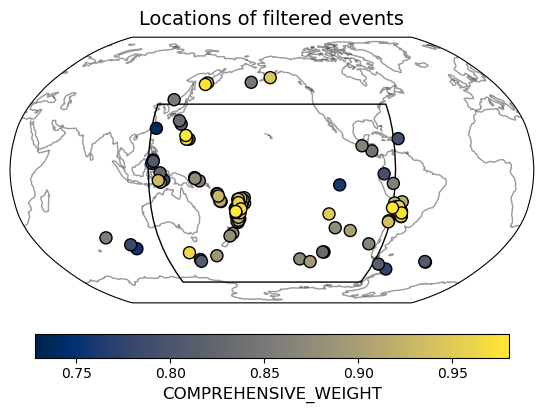

In [13]:
df_filtered_events = df_filtered_events.sort_values(by = [header_of_property_to_plot], ascending = True).reset_index(drop = True)

fig = plt.figure(figsize = (6, 4), constrained_layout = True)

cm = 'cividis'
ax1 = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))
im1 = ax1.scatter(df_filtered_events['EQ_LON'], df_filtered_events['EQ_LAT'], c = df_filtered_events[header_of_property_to_plot], transform = ccrs.PlateCarree(), edgecolor = 'k', marker = 'o', s = 75, cmap = cm, alpha = 1, zorder = 2)
cbar = fig.colorbar(im1, ax = [ax1], orientation = 'horizontal', shrink = 0.8, pad = 0.1)
cbar.ax.set_xlabel(f'{header_of_property_to_plot}', size = 12)

fig.suptitle(f'Locations of filtered events', fontsize = 14)

### Finally, order data according to best potential for azimuthal coverage

In [14]:
df_prioritized = df_filtered_events.copy()
df_prioritized['PRIORITY'] = 0.

while True:
    add_headers = str(input(f'Do you want to add a priority to the filtered event dataframe? [y / n]: '))
    
    if add_headers == 'y':
        priority_header = str(input(f'What is the header of the column you would like to prioritize by?: '))
        priority_favor = str(input(f'Would you like to prioritize high or low values? [high / low]: '))
        priority_weight = float(input(f'What weight would you like to use for this priority? [0 < weight <= 1]: '))
                
        if priority_favor == 'high':
            weighted_priority = (df_prioritized[priority_header] / df_prioritized[priority_header].max()) * priority_weight
        elif priority_favor == 'low':
            weighted_priority = (df_prioritized[priority_header].min() / df_prioritized[priority_header]) * priority_weight
            
        df_prioritized['PRIORITY'] += weighted_priority
        
    elif add_headers == 'n':
        break
    print()

df_prioritized['PRIORITY'] = df_prioritized['PRIORITY'] / df_prioritized['PRIORITY'].max()
df_prioritized = df_prioritized.sort_values(by = ['PRIORITY'], ascending = False).reset_index(drop = True)
display(df_prioritized)

Do you want to add a priority to the filtered event dataframe? [y / n]:  y
What is the header of the column you would like to prioritize by?:  DISPERSION_SCORE
Would you like to prioritize high or low values? [high / low]:  high
What weight would you like to use for this priority? [0 < weight <= 1]:  1


Do you want to add a priority to the filtered event dataframe? [y / n]:  COMPREHENSIVE_WEIGHT


Do you want to add a priority to the filtered event dataframe? [y / n]:  y
What is the header of the column you would like to prioritize by?:  COMPREHENSIVE_WEIGHT
Would you like to prioritize high or low values? [high / low]:  high
What weight would you like to use for this priority? [0 < weight <= 1]:  1


Do you want to add a priority to the filtered event dataframe? [y / n]:  n


,EVENT_ID,EQ_LAT,EQ_LON,RAYPATHS,COMPREHENSIVE_WEIGHT,AZ_RANGE,AZ_SPACING_MEAN,AZ_SPACING_STD,UNIQUE_PHASES,PERCENT_OF_PHASES_REPRESENTED,DIST_FROM_CENTER,AZ_FROM_CENTER,CUMULATIVE_DIST,CUMULATIVE_AZ,DISPERSION_SCORE,DISPERSION_ORDER,PRIORITY
0,2.006111e+13,-26.052,-63.283,446,0.974623,66.198050,0.148760,0.863738,4,50.0,104.251969,117.979123,22984.813332,22286.365058,0.927665,33,1.000000
1,2.007122e+13,-22.954,-70.182,355,0.979231,154.800410,0.437289,4.048298,3,37.5,98.552251,113.833845,22300.605954,22392.980139,0.915412,74,0.996000
2,2.012053e+13,-28.043,-63.094,534,0.964347,141.096171,0.264721,1.770201,5,62.5,104.023109,120.026081,22966.774970,22224.539604,0.926053,41,0.993741
3,2.007072e+13,-22.151,-65.777,485,0.961625,135.764951,0.280506,3.758051,7,87.5,102.693370,113.620085,22788.820433,22400.461735,0.925822,43,0.992186
4,2.006083e+13,-24.403,-67.028,285,0.948931,123.488315,0.434818,3.249798,3,37.5,101.204052,115.708382,22590.075590,22338.993344,0.920419,63,0.982665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2.014072e+13,-19.802,-178.400,151,0.824106,46.189854,0.307932,0.815166,3,37.5,17.909875,203.312528,15445.180621,18762.700119,0.698912,245,0.800723
101,2.013041e+13,-19.141,169.535,23,0.797586,161.592189,7.345099,24.713788,3,37.5,24.694779,228.999807,15748.867215,19294.451805,0.715903,208,0.795665
102,2.007112e+13,-21.185,-178.752,50,0.812020,83.291099,1.699818,5.212257,3,37.5,19.305206,202.456828,15461.651167,18760.118943,0.699207,239,0.794511
103,2.007011e+13,-18.580,-177.847,51,0.756408,122.873981,2.457480,6.514103,3,37.5,16.581506,203.442002,15451.925784,18764.354926,0.699087,240,0.765153


### Plot the filtered events with respect to their new priority score

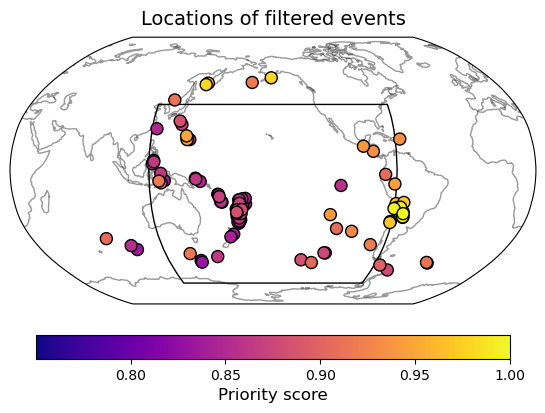

In [15]:
df_prioritized = df_prioritized.sort_values(by = ['PRIORITY'], ascending = True).reset_index(drop = True)
fig = plt.figure(figsize = (6, 4), constrained_layout = True)

ax1 = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))
cm = 'plasma'
im1 = ax1.scatter(df_prioritized['EQ_LON'], df_prioritized['EQ_LAT'], c = df_prioritized['PRIORITY'], transform = ccrs.PlateCarree(), edgecolor = 'k', marker = 'o', s = 75, cmap = cm, alpha = 1, zorder = 2)
cbar = fig.colorbar(im1, ax = [ax1], orientation = 'horizontal', shrink = 0.8, pad = 0.1)
cbar.ax.set_xlabel('Priority score', size = 12)

fig.suptitle(f'Locations of filtered events', fontsize = 14)
fig.savefig('./tech_review_plots/access_CH_priority_events.png', dpi = 300, transparent = True)

### Finally, plot the total and azimuthal coverage of the prioritized list of events

First, compute the gridded total and azimuthal sampling (note, this can take a few minutes).

In [16]:
block_height = 2
df_grid = make_equal_area_grid(block_height, s, w, n, e)
ar_grid = np.array(df_grid)

df_grid_count = df_grid[['BLOCK#']].copy()
df_grid_count['TOTAL_PATHS'] = 0
df_grid_count['TOTAL_SECTORS'] = 0
df_grid_count['SECTOR_1'] = 0
df_grid_count['SECTOR_2'] = 0
df_grid_count['SECTOR_3'] = 0
df_grid_count['SECTOR_4'] = 0
df_grid_count['SECTOR_5'] = 0
df_grid_count['SECTOR_6'] = 0

ar_grid_count = np.array(df_grid_count)
ar_prioritized = np.array(df_prioritized)

event_ct = 1
for event in ar_prioritized[:, 0]:
    event_ct += 1
    ar_event =  np.loadtxt(f'./event_files/{event}.csv', skiprows = 1, delimiter = ',', usecols = (3, 4, 7, 8))
    
    for line in range(len(ar_event)):
        entry_lat = ar_event[line, 0]
        entry_lon = ar_event[line, 1]
        exit_lat = ar_event[line, 2]
        exit_lon = ar_event[line, 3]
        dist = geo_math.GCP_length(entry_lat, entry_lon, exit_lat, exit_lon)
        segment_blocks = []
        
        progress = 0
        run = True
        while run == True:
            progress += 1
            if progress < dist:
                seg_mid_point = geo_math.GCP_point(entry_lat, entry_lon, exit_lat, exit_lon, dist, progress / 2)
                seg_mid_point_block = find_block_id(seg_mid_point[0], seg_mid_point[1], ar_grid)
                seg_mid_point_block_id = np.where(ar_grid_count.T[0] == seg_mid_point_block)[0]
                
                if seg_mid_point_block_id not in segment_blocks:
                    seg_mid_point_az = geo_math.azimuth(seg_mid_point[0], seg_mid_point[1], exit_lat, exit_lon)
                    seg_mid_point_sector = azimuthal_sector(seg_mid_point_az)
                    ar_grid_count[seg_mid_point_block_id, 1] += 1
                    ar_grid_count[seg_mid_point_block_id, seg_mid_point_sector + 2] += 1
                    segment_blocks.append(seg_mid_point_block_id)
                else:
                    pass
            else:
                run = False

for count in range(len(ar_grid_count)):
    sector_array = ar_grid_count[count, 3:]
    sector_count = np.count_nonzero(sector_array)
    ar_grid_count[count, 2] = sector_count

df_grid_count = pd.DataFrame(ar_grid_count, columns = df_grid_count.columns)

Once the sampling is computed, plot the coverage maps. Total coverage is defined as the number of paths that sample a given grid area. Azimuthal coverage is defined as the number of azimuthal sectors (defined as six 30 degree sectors from 0 - 180 degrees) with coverage in a given grid area.

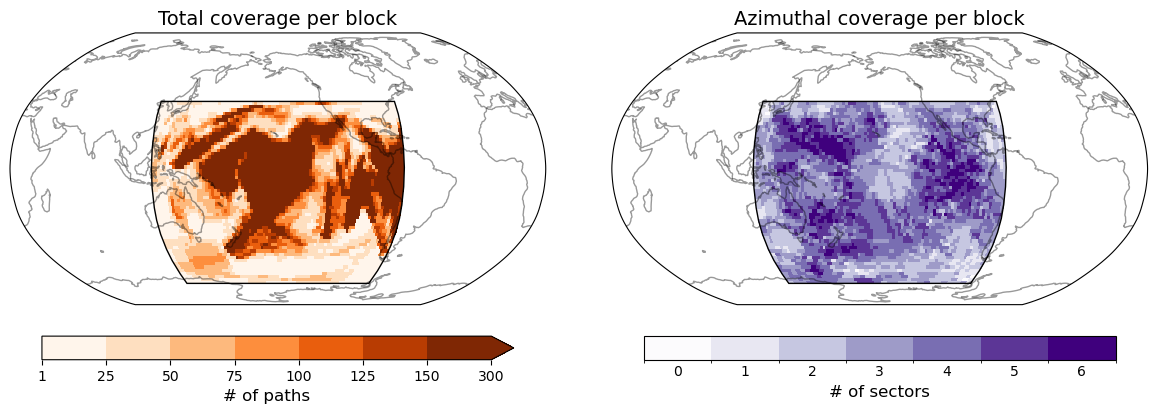

In [19]:
fig = plt.figure(figsize = (12, 4), constrained_layout = True)
box_lats = np.arange(s, n + block_height, block_height)
box_lons = np.arange(0, box_sampling_input.width + block_height, block_height)
box_lons = box_lons + w
box_lons[np.where(box_lons >= 180)[0]] = box_lons[np.where(box_lons >= 180)[0]] - 360

## total coverage:
ax1 = fig.add_subplot(1, 2, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)

cov_bins = [1, 25, 50, 75, 100, 125, 150, 300]
total_paths = coverage_mesh(ar_grid, ar_grid_count, block_height, 1)
cov_norm = mpl.colors.BoundaryNorm(cov_bins, mpl.cm.Oranges.N)
im1 = ax1.pcolormesh(box_lons, box_lats, total_paths, transform = ccrs.PlateCarree(), cmap = 'Oranges', norm = cov_norm)
ax1.set_title(f'Total coverage per block', fontsize = 14)
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'k', fill = False, alpha = 1, transform = ccrs.PlateCarree(), linewidth = 1))

cov_cbar_coverage = fig.colorbar(im1, ax = ax1, orientation = 'horizontal', shrink = 0.8, pad = 0.1, extend = 'max')
cov_cbar_coverage.ax.tick_params(labelsize = 10)
cov_cbar_coverage.ax.set_xlabel('# of paths', size = 12)

## azimuthal coverage:
ax2 = fig.add_subplot(1, 2, 2, projection = ccrs.Robinson(central_longitude = map_center))
ax2.set_global()
ax2.coastlines(alpha = 0.4)

sector_bins = list(range(0, azimuthal_sectors + 2, 1))
total_sectors = coverage_mesh(ar_grid, ar_grid_count, block_height, 2)
sector_norm = mpl.colors.BoundaryNorm(sector_bins, mpl.cm.Purples.N)
im2 = ax2.pcolormesh(box_lons, box_lats, total_sectors, transform = ccrs.PlateCarree(), cmap = 'Purples', norm = sector_norm)
ax2.set_title(f'Azimuthal coverage per block', fontsize = 14)
ax2.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'k', fill = False, alpha = 1, transform = ccrs.PlateCarree(), linewidth = 1))

sector_cbar_coverage = fig.colorbar(im2, ax = ax2, orientation = 'horizontal', shrink = 0.8, pad = 0.1, extend = 'neither')
sector_cbar_coverage.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
sector_cbar_coverage.set_ticklabels(sector_bins[:-1])
sector_cbar_coverage.ax.tick_params(labelsize = 10, size = 0)
sector_cbar_coverage.ax.set_xlabel('# of sectors', size = 12);